Importing all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


Setting all the Constants

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE= 32
CHANNELS = 3
EPOCHS = 50

Importing data into tensorflow dataset object.

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\ASUS\Downloads\4th_Sem_Project\archive\PlantVillage", 
    shuffle=True,
    image_size = ( IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, label_batch in dataset.take(1) :
    print ( image_batch. shape)
    print ( label_batch. numpy ( ) )

(32, 256, 256, 3)
[1 0 1 0 1 1 1 1 0 0 1 2 2 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. 
Second element is a batch of 32 elements of class labels.


Visualizing some of the images from our dataset.

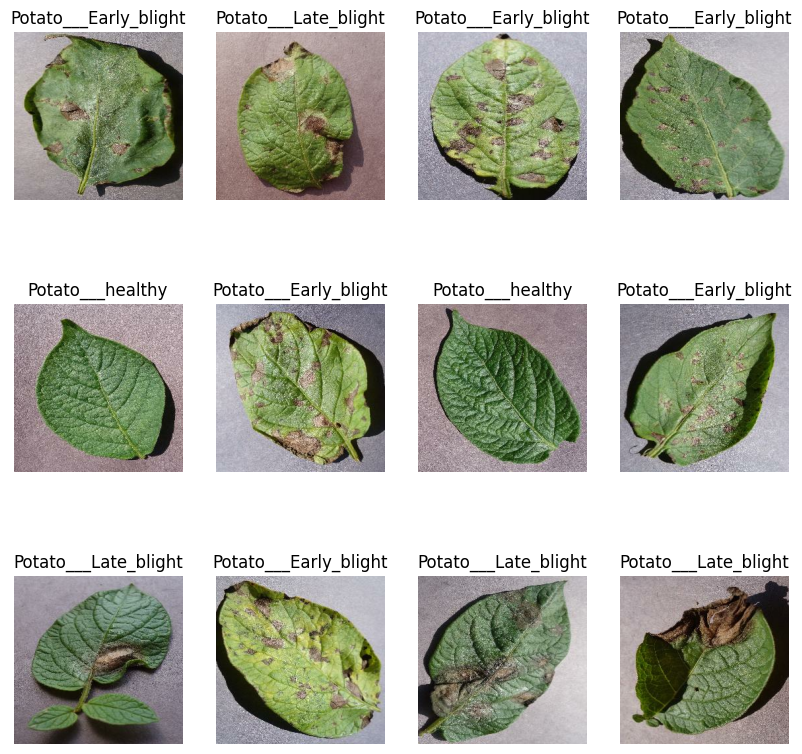

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset. take(1) :
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]] )
        plt.axis("off")

Function to Split Dataset
Dataset should be de into 3 subsets, namely:

1. Training: Dataset to be used while training.
2. Validation: Dataset to be tested against while training.
3. Test: Dataset to be tested against after we trained a model.

In [8]:
len(dataset)

68

In [9]:
%80 == training
%20 == 10% validation, 10% test

UsageError: Line magic function `%80` not found.


In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds= dataset. take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds. skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [17]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data Augmentation-
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Building the Model -
Creating a Layer for Resizing and Normalization -

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

Applying Data Augmentation to Train Dataset

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture -
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [26]:
#use of CNN
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3, 3), activation = "relu" ,input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3, 3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3, 3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3, 3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    
])

model.build(input_shape=input_shape)


In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

Compiling the Model -
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 53s 949ms/step - loss: 0.8580 - accuracy: 0.5619 - val_loss: 0.7285 - val_accuracy: 0.6719
Epoch 2/50
54/54 [==============================] - 47s 873ms/step - loss: 0.6587 - accuracy: 0.7199 - val_loss: 0.6142 - val_accuracy: 0.7708
Epoch 3/50
54/54 [==============================] - 48s 881ms/step - loss: 0.4996 - accuracy: 0.7963 - val_loss: 0.8336 - val_accuracy: 0.6198
Epoch 4/50
54/54 [==============================] - 50s 913ms/step - loss: 0.3932 - accuracy: 0.8391 - val_loss: 0.4804 - val_accuracy: 0.8333
Epoch 5/50
54/54 [==============================] - 53s 983ms/step - loss: 0.2934 - accuracy: 0.8825 - val_loss: 0.2341 - val_accuracy: 0.9115
Epoch 6/50
54/54 [==============================] - 53s 970ms/step - loss: 0.2020 - accuracy: 0.9213 - val_loss: 0.5172 - val_accuracy: 0.7917
Epoch 7/50
54/54 [==============================] - 50s 919ms/step - loss: 0.1873 - accuracy: 0.9311 - val_loss: 0.1823 - val_accuracy: 0.9271

In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 193ms/step - loss: 0.5679 - accuracy: 0.8906


You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy.

In [31]:
scores

[0.567878246307373, 0.890625]

Scores is just a list containing loss and accuracy value.

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

50

In [37]:
#shows loss for first 5 epochs
history.history['loss'][:5]

[0.8580307364463806,
 0.6586800217628479,
 0.49960702657699585,
 0.39323514699935913,
 0.29337671399116516]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

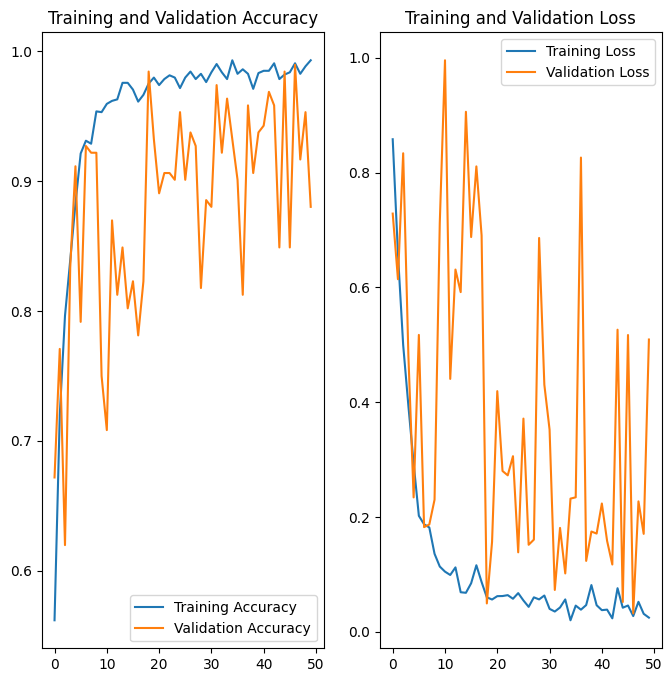

In [39]:
#matplotlib
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 513ms/step
predicted label: Potato___Late_blight


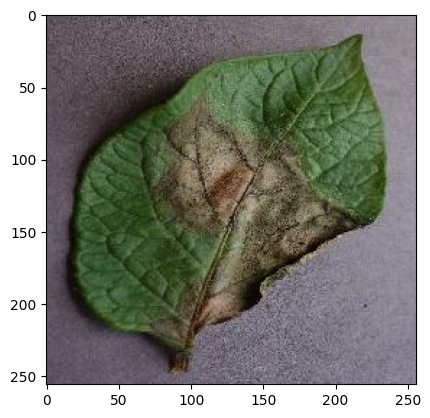

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Function for inference

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


Running the inference on the few sample images

1/1 [==============================] - 0s 16ms/step


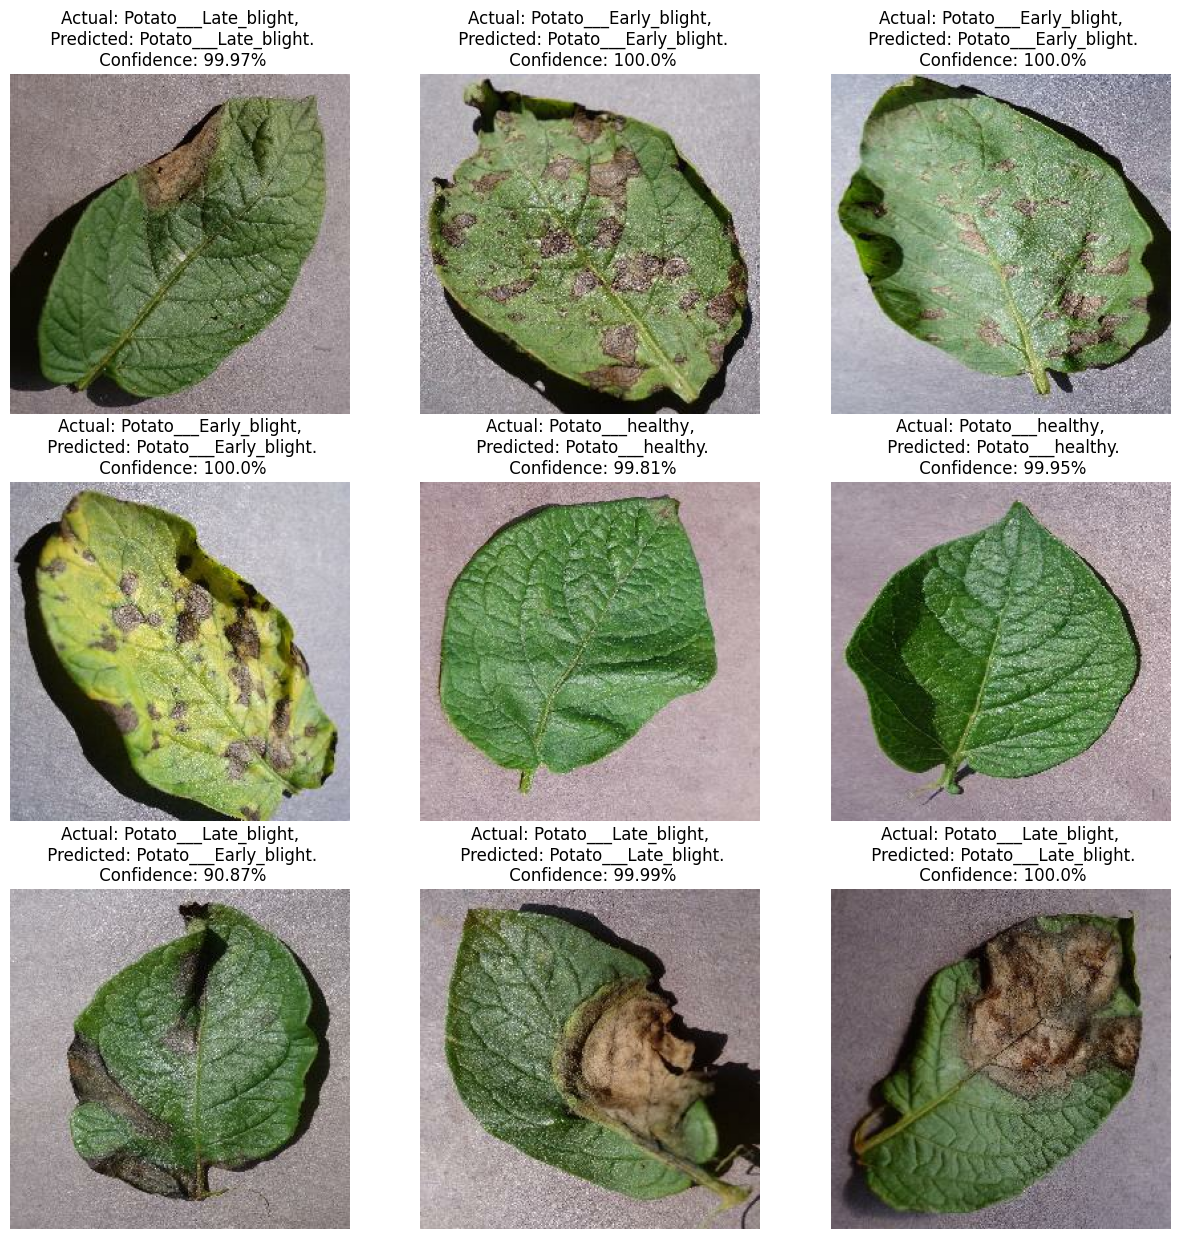

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the model

In [43]:
import os
model_version=max([int(i) for i in os.listdir("C:/Users/ASUS/Downloads/4th_Sem_Project/model") + [0]])+1
model.save(f"C:/Users/ASUS/Downloads/4th_Sem_Project/model/{model_version}")

INFO:tensorflow:Assets written to: C:/Users/ASUS/Downloads/4th_Sem_Project/model/3\assets


INFO:tensorflow:Assets written to: C:/Users/ASUS/Downloads/4th_Sem_Project/model/3\assets
